In [1]:
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
from glob import glob
import pandas as pd
import os
import re
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from tqdm import tqdm
import skimage

import separate_table

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

font_path = "data/fonts-japanese-mincho.ttf"

In [3]:
def remove_line(img):
    binary = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.blur(binary, ksize=(3, 3))
    # Otsu's thresholdin
#     binary = cv2.erode(binary, np.ones((2,2), np.uint8), iterations=1)
#     binary = cv2.dilate(binary, np.ones((2,2), np.uint8), iterations=1)
    _,binary = cv2.threshold(binary,200,255,cv2.THRESH_BINARY)
#     labels = skimage.measure.label(binary, neighbors=8, background=0)
#     mask = np.zeros(binary.shape, dtype="uint8")
#     labels
    
#     # loop over the unique components

#     for label in tqdm(np.unique(labels)):
#     # if this is the background label, ignore it
#         if label == 0:
#             continue
    
#         # otherwise, construct the label mask and count the
#         # number of pixels 
#         labelMask = np.zeros(binary.shape, dtype="uint8")
#         labelMask[labels == label] = 255
#         numPixels = cv2.countNonZero(labelMask)
        
#         # if the number of pixels in the component is sufficiently
#         # large, then add it to our mask of "large blobs"
#         if numPixels > 10:
#             mask = cv2.add(mask, labelMask)
#     horizontal_img = binary.copy()
#     vertical_img = binary.copy()
#     
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
#     horizontal_img = cv2.erode(horizontal_img, kernel, iterations=1)
#     horizontal_img = cv2.dilate(horizontal_img, kernel, iterations=1)
# 
#     
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
#     vertical_img = cv2.erode(vertical_img, kernel, iterations=1)
#     vertical_img = cv2.dilate(vertical_img, kernel, iterations=1)
# 
#     mask_img = horizontal_img + vertical_img
#     mask_indx = mask_img == 255
#     img[mask_indx] = 255
    
#     return img 
    return binary
def df_to_image(df, img):
    overlay = np.full(img.shape, 255, dtype=np.uint8)
    pil_image = Image.fromarray(overlay)
    draw = ImageDraw.Draw(pil_image)
    for index, row in df.iterrows():
        if row['conf'] != -1:
            # cv2.putText(overlay,row['text'],(row['left'],row['top'] + row['height']), cv2.FONT_HERSHEY_SIMPLEX, img.shape[0]/1000.0,0,1,cv2.LINE_AA)
            draw.text((row['left'],row['top'] + row['height']), row['text'], font=ImageFont.truetype(font_path, np.max(img.shape)//100), fill=0)
    return np.array(pil_image)

In [4]:
def paragraph_to_image(paragraphs, img):
    overlay = np.full(img.shape, 255, dtype=np.uint8)
    pil_image = Image.fromarray(overlay)
    draw = ImageDraw.Draw(pil_image)
    for paragraph in paragraphs:
        for phrase in paragraph:
            left, top, height, width = phrase[1]
            draw.text((left, top + height), phrase[0], font=ImageFont.truetype(font_path, np.max(img.shape)//100), fill=0)
    return np.array(pil_image)

In [5]:
def is_table_header(line, headers):
    '''
    check if line include some key word of headers or not
    '''
    for header in headers:
        if header in "".join([item[0] for item in line]):
            return True
    return False
def is_next(previous, current, is_phrase=True):
    '''
    check if 2 input texts (previous, current) should be grouped together or not
    if 2 texts are close to each other then it should be treated as same text
    there are 2 situation:
    - input are 2 phrases then check the top down position
    - input are 2 words then check the left right position
    '''
    # in case arg is phrase type
    if is_phrase:
        # parameters
        space_param = 3
        ratio_param = 0.5
        
        # if the space between 2 word are too far
        if current['left'] - previous['left'] > space_param * previous['width']:
            return False
        # if height of 2 words are too different
        #if abs(current['height'] - previous['height']) / current['height'] > ratio_param:
        #    return False
        return True
    # in case arg is paragraph
    else:
        # parameters
        space_param = 2.0
        ratio_param = 1.0
        
        l_c, t_c, h_c, w_c = current[1]
        l_p, t_p, h_p, w_p = previous[1]
        # if the space between 2 phrase are too far
        if t_c - t_p > space_param * h_p:
            return False
        # if the position of 2 phrases are not aligned (left_aligned, middle_aligned, right_aligned)
        if min(abs(l_c - l_p), abs(l_c + w_c / 2 - l_p - w_p / 2), abs(l_c + w_c - l_p - w_p)) > ratio_param * h_p:
            return False
        return True
def process_row(rows):
    '''
    merge multiple texts with position into one line and its position
    '''
    line = ""
    left, top, height, width = (9999,9999,0,0) 
    for row in rows:
        line += row['text']
        left = min(left, row['left']) # Left of a line of characters should be the character on the left
        top = min(top, row['top'])    # Top of a line of characters should be the the min top of all characters (each character's top is not the same)
        height = max(height, row['top'] + row['height'] - top)
        width = max(width, row['left'] + row['width'] - left)
    return (line, (left, top, height, width))
def process_line(df):
    '''
    @input: a dataframe
    divide a data frame of line into different elements(blocks) 
    if these blocks locate far from eachother
    @output: a list of tupple (phrase, location)
    '''
    # result will be saved here
    phrases = []
    
    # initialize for for_loop
    previous_row = df.iloc[0]
    rows = [df.iloc[0]]
    
    for indx in range(1, df['text'].count()):
        row = df.iloc[indx]
        if is_next(previous_row, row):
            rows.append(row)
        else:
            previous_item = None
            text, location = process_row(rows)
            phrases.append((text, location))
            rows = [row]
        previous_row = row
    if len(rows) != 0:
        text, location = process_row(rows)
        phrases.append((text, location))
    return phrases
 
def process_phrases(blocks):
    '''
    # Sample of blocks
    #############################################################################################
    [('納品書', (764, 165, 41, 198))]
    [('御中', (661, 267, 46, 68)), ('納品No.DUA①②③①②④0⑤0⑤A', (977, 269, 41, 616))]
    [('ご担当:', (188, 343, 42, 103)), ('様', (592, 348, 28, 16)), ('納品日', (977, 344, 42, 89)), ('⑳①⑨/⑨/①⑧', (1465, 350, 26, 128))]
    [('件名:', (145, 426, 65, 90)), ('oo株式会社', (897, 423, 65, 155))]
    [('下記のとおり、納品致します。', (185, 480, 64, 408)), ('〒', (901, 499, 25, 21))]
    [('東京都新宿区新宿①.②③', (899, 529, 65, 306))]
    [('新宿第①ビル②階', (898, 596, 28, 211))]
    [('納期:', (169, 644, 39, 70)), ('TEL:', (972, 648, 34, 58))]
    [('支払条件:月末締め翌月末払い', (114, 679, 64, 424)), ('FAX', (969, 702, 19, 61))]
    [('E-Mail:', (938, 749, 21, 92))]
    [('担当', (954, 776, 65, 66))]
    [('合計金額\\0(税込)', (149, 875, 52, 611))]
    [('No.摘要', (118, 957, 67, 408)), ('数量単価', (863, 960, 64, 258)), ('金額', (1375, 960, 64, 64))]
    [('小計', (863, 1612, 64, 76)), ("'", (1208, 1619, 2, 2)), ('vo', (1564, 1619, 35, 36))]
    [('消費税', (847, 1662, 64, 104)), ('vo', (1564, 1668, 35, 36))]
    [('合計_', (863, 1711, 64, 109)), ('vo', (1564, 1718, 35, 36))]
    [('備考', (149, 1898, 46, 62))]
    #############################################################################################
    group a list of phrases into a paragraphs if these phrases are close to each other
    '''
 
    # declare a list containing items, that each item is a group of pharse that is close to each other
    paragraphs = [[item] for item in blocks[0]]
    
    for block in blocks[1:]:
        # declare a temporarory paragraphs to store new paragraph into
        tmp_paragraphs = []
        for current_item in block:
            for indx, paragraph in enumerate(paragraphs):
                # if current_item is close to the last item of candidate, add it to that paragraph
                if is_next(paragraph[-1], current_item, is_phrase=False):
                    paragraph.append(current_item)
                    break
                # other-wise, declare a new paragraph as this current_item
                if indx == len(paragraphs) - 1:
                    tmp_paragraphs.append([current_item])
        # update paragraphs
        if len(tmp_paragraphs) != 0:
            paragraphs.extend(tmp_paragraphs)
    return paragraphs

In [6]:
table_header = ['ご注文日', '商品ID', '商品名', '数量', '単位', '単価', '小計']

# OLD

 

ご請求書

604-8151

〒

京都市中京区鳥丸通央薬師西入ル橋弁慶町227
第12長谷ビル6F
〒604-8151

京都市中京区橋弁慶町227
第12長谷ビル5F
御買上商事株式会社御中
電話:075-000-0000FAX:075-000-0000

株式会社みんなのエクセル
  
ご請求日
\1.050.00

2019年4月2日
 
 
4田江
負担にてお願い申し上げます。
お振込先:大文字銀行金閣寺支店(普)30300001

ご請求額
当月

    
2019/4/

('ご注文日', (0, 0, 3508, 2480))
('EN', (421, 994, 27, 16))
('四', (204, 931, 97, 240))
('     ', (0, 1201, 1012, 0))
(' ', (1347, 3241, 5, 960))
('SS', (1737, 3202, 33, 22))
('to', (1715, 3202, 33, 19))
('敵', (1519, 3198, 41, 41))
('1', (1473, 3144, 95, 41))
('イス', (1427, 3199, 38, 11))
('ーー', (757, 3201, 10, 25))
('ーー', (755, 3219, 10, 23))
('  ', (0, 2943, 365, 0))
('※恐れ入りますが、振込手数料は貴社', (212, 3202, 31, 539))


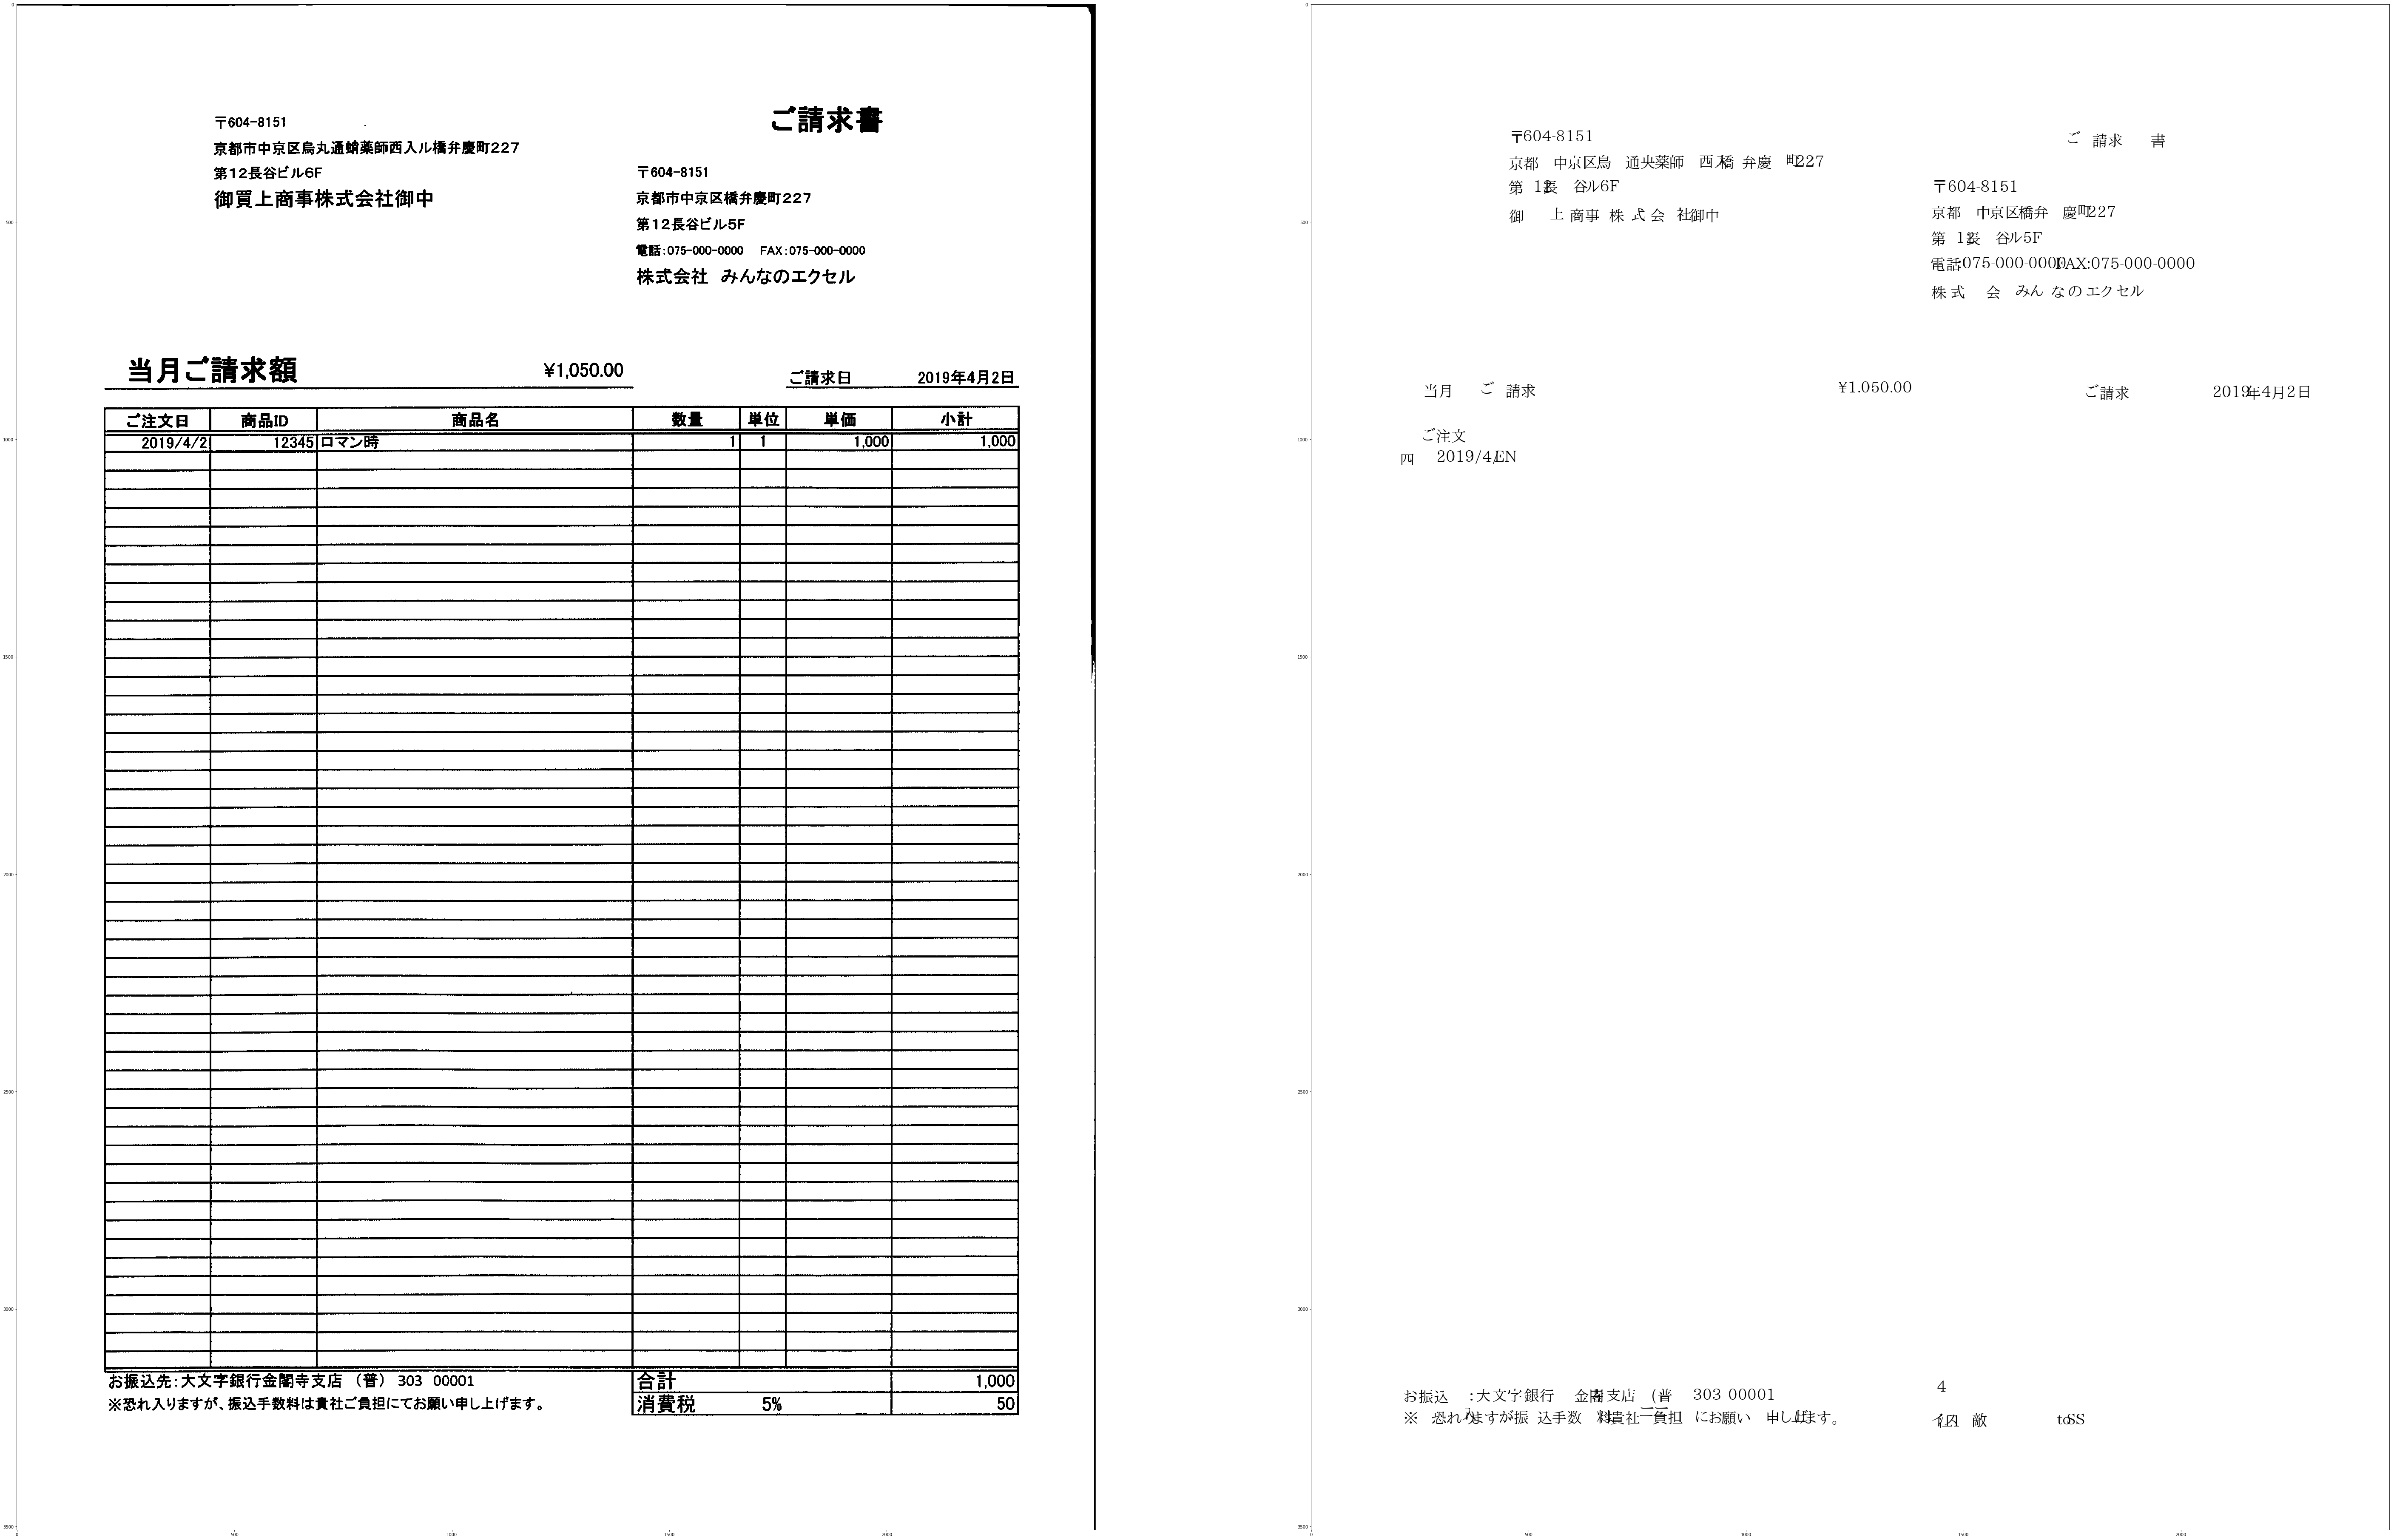

In [8]:
input_folder = "data"
image_paths = []
image_paths.extend(glob(os.path.join(input_folder, "*.png")))
image_paths.extend(glob(os.path.join(input_folder, "*.jpg")))
image_paths = ["data/005.jpg"]
fig=plt.figure(figsize=(100, 100))
rows = len(image_paths)
cols = 2
for i, path in enumerate(image_paths[:1]):
    img = cv2.imread(path)
    img = remove_line(img)
    # dealing with rotated image. Choose the best image's direction based on tesseract confidence score
    df = None
    conf = -1 
    _img = None
    for i in range(1):
        img = (np.rot90(img) if i != 0 else img)
        _df = pytesseract.image_to_data(Image.fromarray(img), lang="jpn", output_type=Output.DATAFRAME)
        _df.columns = _df.columns.str.strip()
        _df = _df.dropna()
        if conf < _df['conf'].mean():
            conf = _df['conf'].mean()
            df = _df
            _img = img.copy()
    
    df.columns.str.strip()
    df = df.dropna()
    df = df.drop(columns=['level', 'page_num'])
    df_lines = []
    for _, block in df.groupby('block_num'):
        for _, parse in block.groupby('par_num'):
            for _, line in parse.groupby('line_num'):
                df_lines.append(line)
    phrases = []
    list_table = []
    table_top = _img.shape[0]
    for df_line in df_lines:
        list_lines = process_line(df_line)
        left, top, height, width = list_lines[0][1]
        if is_table_header(list_lines, table_header) or top > table_top:
            table_top = min(top, table_top)
            list_table.append(list_lines)
        else:
            phrases.append(list_lines)

    paragraphs = process_phrases(phrases)
    new_img = df_to_image(df, _img)
    for paragraph in paragraphs:
        for phrase in paragraph:
            print(phrase[0])
        print()
    for table in list_table:
        print(table[0])
#     new_img = paragraph_to_image(paragraphs, _img)
#     
#     cv2.imwrite(os.path.join(input_folder, os.path.basename(path).split(".")[0] + "_output." + os.path.basename(path).split(".")[1]), new_img)
    
    fig.add_subplot(rows, cols, i * cols + 1)
    plt.imshow(_img.copy(), cmap='gray')
    fig.add_subplot(rows, cols, i * cols + 2)
    plt.imshow(new_img.copy(), cmap='gray')
plt.show()

# NEW

In [7]:
def process_meta(img):
    img = remove_line(img)
    # dealing with rotated image. Choose the best image's direction based on tesseract confidence score
    df = None
    conf = -1 
    _img = None
    for i in range(1):
        img = (np.rot90(img) if i != 0 else img)
        _df = pytesseract.image_to_data(Image.fromarray(img), lang="jpn", output_type=Output.DATAFRAME)
        _df.columns = _df.columns.str.strip()
        _df = _df.dropna()
        if conf < _df['conf'].mean():
            conf = _df['conf'].mean()
            df = _df
            _img = img.copy()
    
    df.columns.str.strip()
    df = df.dropna()
    df = df.drop(columns=['level', 'page_num'])
    all_blocks = []
    list_table = []
    table_top = _img.shape[0]
    for _, block in df.groupby('block_num'):
        str_block = []
        for _, parse in block.groupby('par_num'):
#             str_parse = []
            for _, line in parse.groupby('line_num'):
                list_lines = process_line(line)
                left, top, height, width = list_lines[0][1]
                if is_table_header(list_lines, table_header) or top > table_top:
                    table_top = min(top, table_top)
                    list_table.append(list_lines)
                else:
                    str_block.append(list_lines) 
#                     str_parse.append(list_lines) 
#             str_block.append(str_parse)
        all_blocks.append(str_block)
    return all_blocks

In [9]:
input_folder = "data"
image_paths = []
image_paths.extend(glob(os.path.join(input_folder, "*.png")))
image_paths.extend(glob(os.path.join(input_folder, "*.jpg")))
image_paths = ["data/20190402203425465_0001.jpg"]
fig=plt.figure(figsize=(100, 100))
rows = len(image_paths)
cols = 2
for i, path in enumerate(image_paths[:1]):
    img = cv2.imread(path)
    meta_img, table_img = separate_table.run(img)
    all_blocks = process_meta(meta_img)
#     
#     cv2.imwrite(os.path.join(input_folder, os.path.basename(path).split(".")[0] + "_output." + os.path.basename(path).split(".")[1]), new_img)
    
#     fig.add_subplot(rows, cols, i * cols + 1)
#     plt.imshow(meta_img.copy(), cmap='gray')
#     fig.add_subplot(rows, cols, i * cols + 2)
#     plt.imshow(table_img.copy(), cmap='gray')
# plt.show()

<Figure size 7200x7200 with 0 Axes>

### Not Ready yet

In [10]:
post_number = r"〒\d{3}-\d{4}"
address = r".*(都|道|府|県|区|市|町|丁).*"
building = r".*(ビル|マンション|ハイツ|アパート).*"
phone_number = r".*0\d*-\d*-\d*"
money_number = r".*(v|\\)\d*\.\d*"
date = r".*\d{2,4}.\d{1,2}.\d{1,2}"
dest = r".*御中"
organize = r".*株式会社.*"
title = r"ご請求書"

In [11]:
interested_tags = [('from', organize), ('to', dest), ('total_bill', money_number), ('date', date), ('title', title)]

def tag_paragraph(blocks):
    '''
    find the meaning of each paragraph by regular expression
    label paragraph using tag
    '''
    tags = {}
    tags['unknown'] = []
    for block in blocks:
        for idx, lines in enumerate(block):
            line = "".join([line[0] for line in lines])
            if re.match(organize, line):
                if re.match(dest, line):
                    tags["to"] = block
                    continue
                else: 
                    tags["from"] = block
                    continue
            elif re.match(money_number, line):
                tags["total_bill"] = re.findall(r"\\.*", line)[0]
                continue
            elif re.match(date, line):
                tags["date"] = re.findall(r"\d{2,4}.\d{1,2}.\d{1,2}.", line)[0]
                continue
            elif re.match(title, line):
                tags["title"] = line
                continue
            if idx == len(block) - 1:
                tags['unknown'].append(block)
        
    return tags
def tag_detail(blocks):
    _dict = {}
    for block in blocks:
        for lines in block:
            for line, _ in lines:
                if re.match(post_number, line):
                    _dict["post"] = line
                if re.match(address, line):
                    _dict["address"] = line
                if re.match(building, line):
                    _dict["building"] = line
                if re.match(phone_number, line):
                    _dict["TEL"] = line
                if re.match(organize, line):
                    _dict["ORG"] = line
    return _dict
tags = tag_paragraph(all_blocks)
tags['from'] = tag_detail([tags['from']])
tags['to'] = tag_detail([tags['to']] + tags['unknown'])

In [12]:
print(tags['unknown'])

[[[(' ', (1492, 0, 16, 568))]], [[(' ', (1, 0, 14, 543))]], [[('〒604-8151', (468, 257, 29, 160)), ('ご請求書', (1746, 233, 62, 254))], [('京都市中京区烏丸通輔薬師西入ル橋弁鹿町227', (0, 0, 789, 2480))], [('第12長谷ビル6F', (465, 371, 31, 249))]], [[('御買上商事株式会社御中', (0, 0, 789, 2480)), ('京都市中京区橋弁鹿町227', (1435, 429, 33, 400))], [('第12長谷ビル5F', (1436, 489, 32, 249))]]]


In [5]:
def write_to_excel(df, ws):
    df = df.sort_values(by=['top', 'left'])
    count = 1
    for _, line_df in df.groupby('line_num'):
        line = "".join(line_df['text'].tolist())
        ws.cell(column=1, row=count, value=line)
        count += 1
    return ws

In [5]:
wb = Workbook()
ws = wb.active
ws.title = "Hoge"
ws = write_to_excel(block_df[3], ws)
wb.save(filename="hoge.xlsx")

In [26]:
print(re.match("当月ご請求額\1.050.00", src))


None


In [63]:
print(" ".encode())

b' '


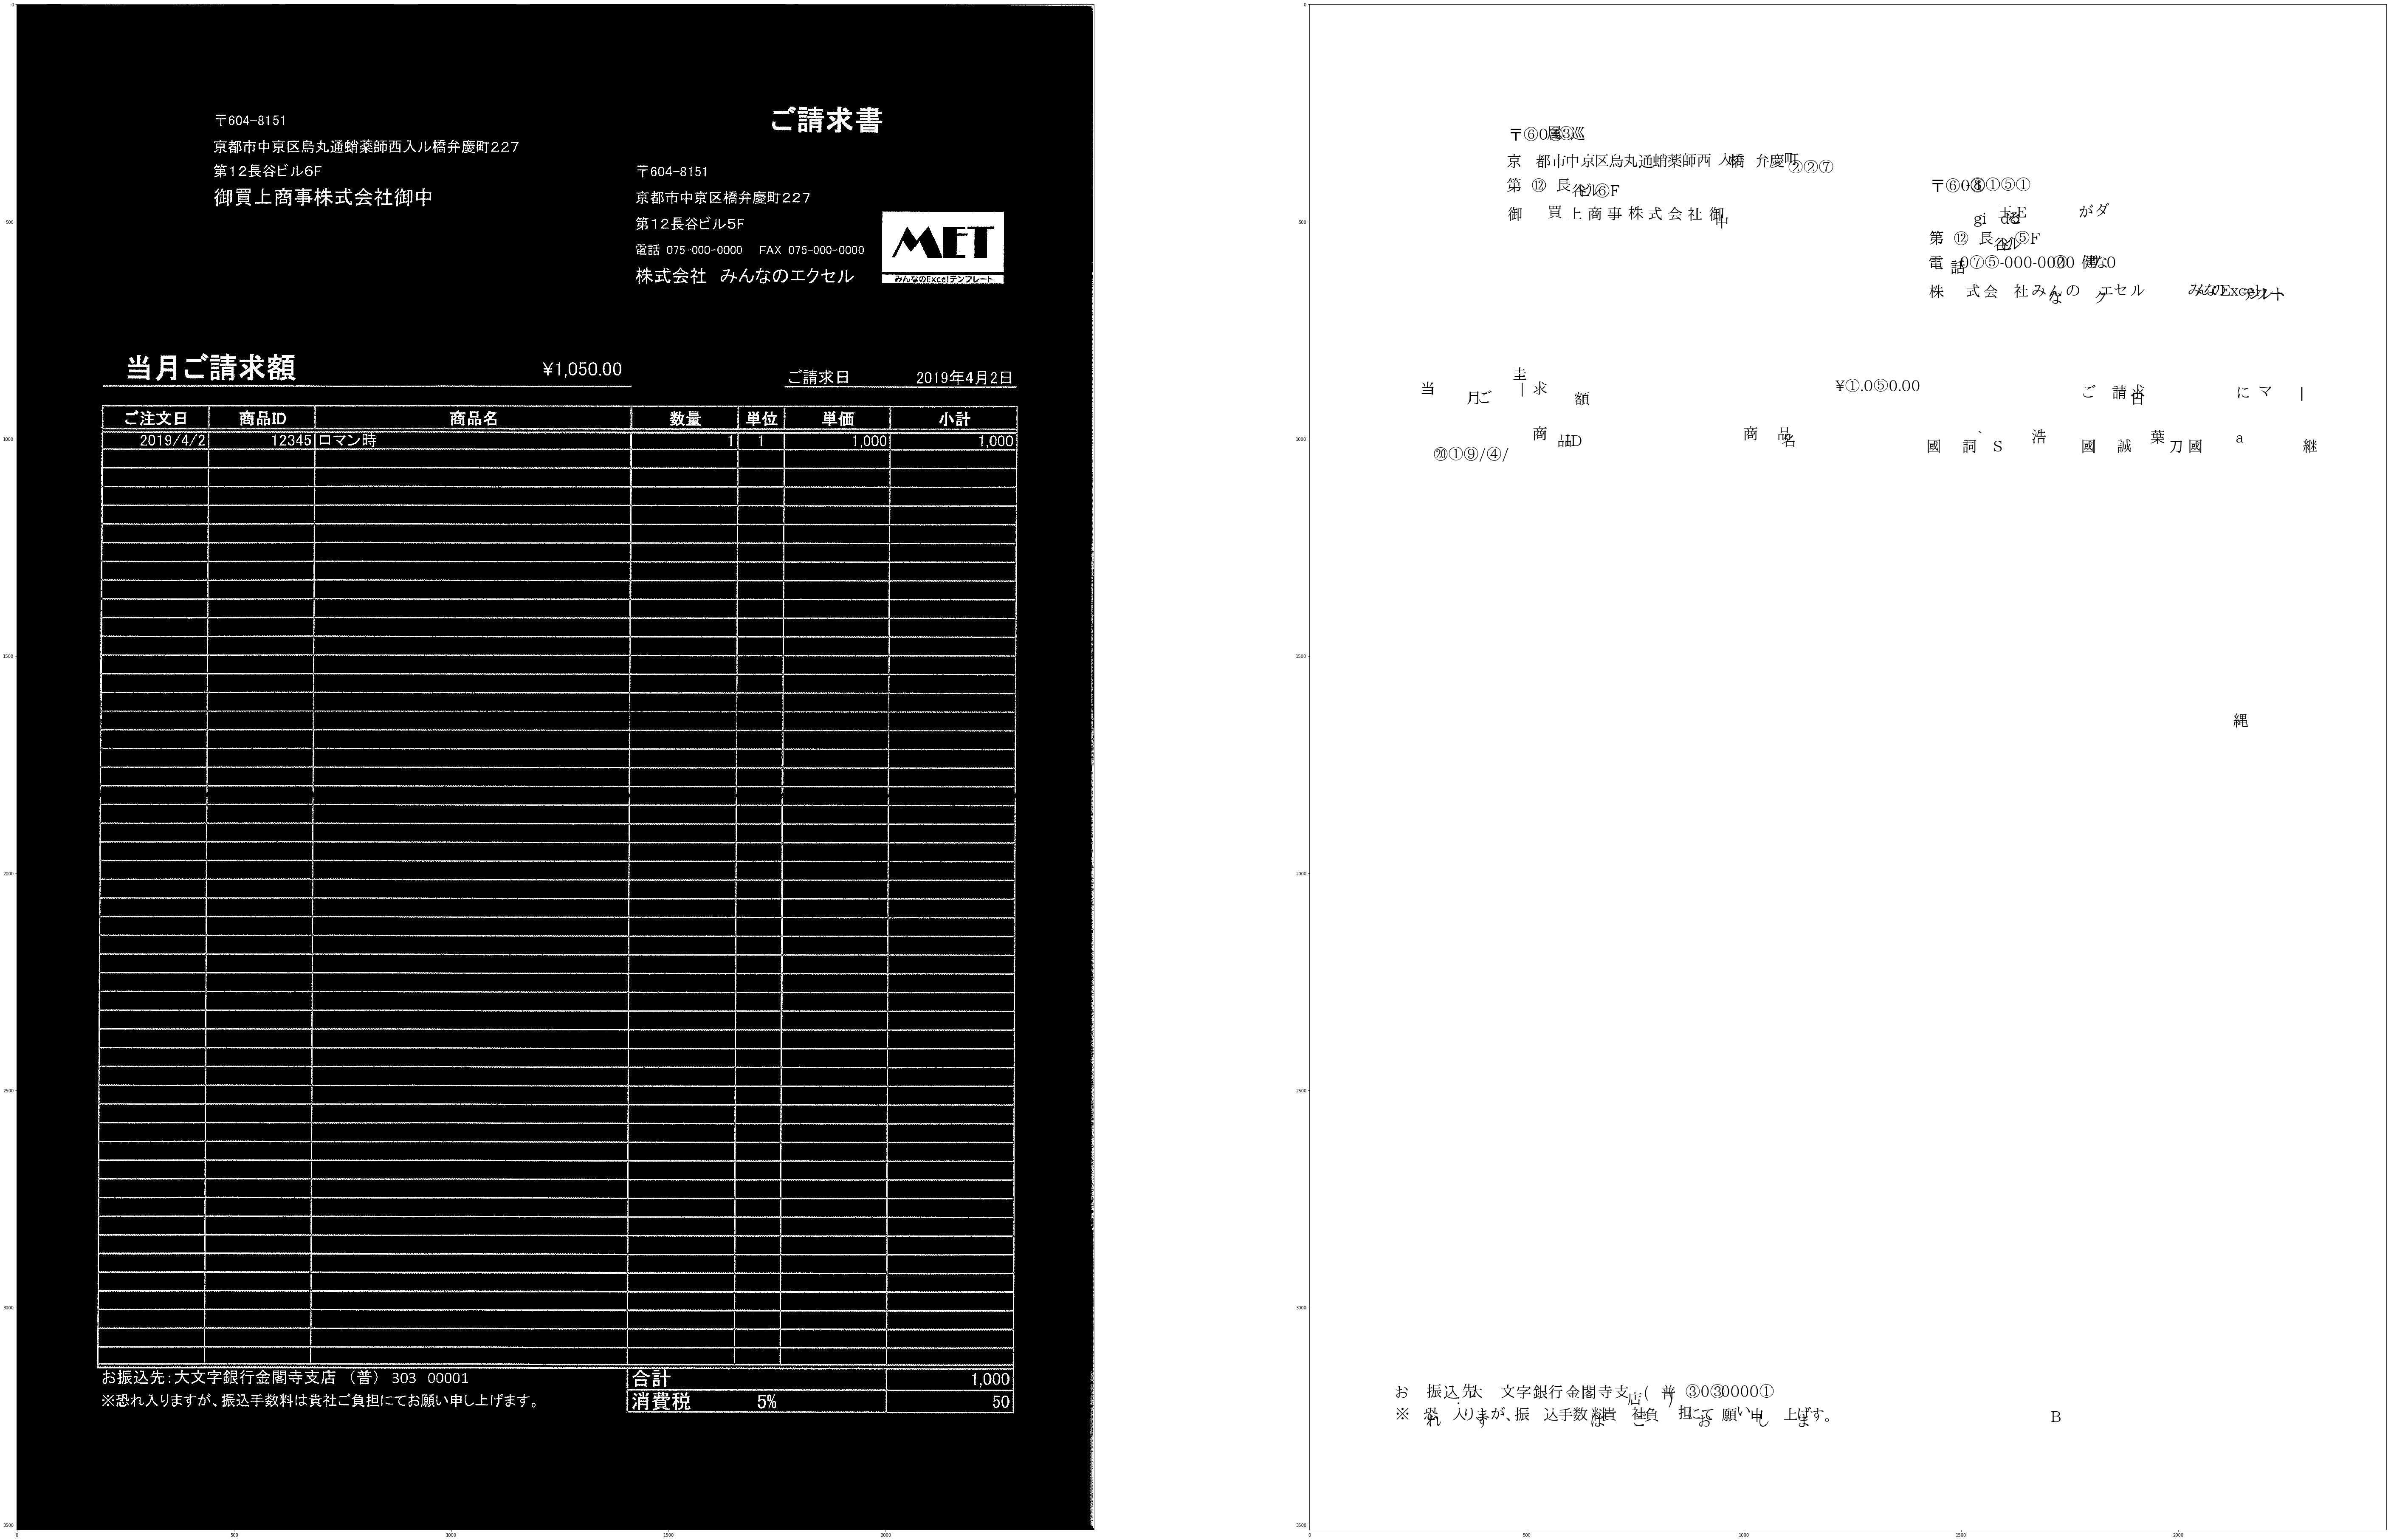

In [34]:
fig=plt.figure(figsize=(100, 100))
rows = len(image_paths)
cols = 2
fig.add_subplot(rows, cols, i * cols + 1)
plt.imshow(_img.copy(), cmap='gray')
fig.add_subplot(rows, cols, i * cols + 2)
plt.imshow(new_img.copy(), cmap='gray')
plt.show()

In [37]:
path = "data/hoge.jpg"
img = cv2.imread(path)
# dealing with rotated image. Choose the best image's direction based on tesseract confidence score
df = pytesseract.image_to_data(Image.fromarray(img), lang="jpn", output_type=Output.DATAFRAME)
print(df.head())

   level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
0      1         1          0        0         0         0     0    0    360   

   height  conf  text  
0     137    -1   NaN  


In [10]:
for _, block in df.groupby('block_num'):
    for _, parse in block.groupby('par_num'):
        hoge = ""
        for indx, row in parse.iterrows():
            hoge += row['text']
        print(hoge)

〒604-8151京都市中京区烏丸通晴薬師西入ル橋弁雇町227第12長谷ビル6F
御買上商事株式会社御中
当月ご請求額\1.050.00
ご注文日商品D商品名2019/4/212345ロマン時
お振込先:大文字銀行金閣寺支店(普)30300001※恐れ入りますが、振込手数料は貴社ご負担にてお願い申し上げます。
ご請求書
〒604-8151京都市中京区格弁鹿町227
第12長谷ビル5F
電話:075-000-0000FAX:075-000-0000株式会社みんなのエクセル
ご請求日2019年4月2日数量単位単価小計111.0001.000合計1.000消費5%50
 
